<a href="https://colab.research.google.com/github/josh-truong/digit-classification/blob/main/digit_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from keras.datasets import mnist
from matplotlib import pyplot as plt
from matplotlib import gridspec
import time

%matplotlib inline

# Helper Functions

In [2]:
def show_images(images, nrow=2, ncol=5, img_w=28, img_height=28):
  images = images if (len(images.shape) == 2) else np.array([images])
  n = len(images)
  (nrow,ncol) = (1, n) if(n < nrow*ncol) else (nrow, ncol)

  indices = np.random.choice(len(images), size=(nrow*ncol), replace=True)
  images = images[indices, :]

  fig = plt.figure(figsize=(ncol+1, nrow+1)) 
  gs = gridspec.GridSpec(nrow, ncol,
          wspace=0.0, hspace=0.0, 
          top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
          left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

  for n, img in enumerate(images):
    row, col = n // ncol, n % ncol
    ax = plt.subplot(gs[row, col])
    ax.imshow(img.reshape(img_w,img_height))
    ax.set_xticklabels([]); ax.set_yticklabels([])

# MNIST Dataset
Kaggles MNIST dataset contains 785 columns representing a 28x28 image label(1) and pixel values(784). The pixel values of the image can range from 0 to 255.

https://www.kaggle.com/competitions/digit-recognizer

In [3]:
num_labels = 10
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# shuffle training dataset
shuffle_index = np.random.permutation(len(x_train))
x_train, y_train = x_train[shuffle_index], y_train[shuffle_index]

print('Training Dataset: {0} {1}'.format(x_train.shape, y_train.shape))
print('Training Dataset: {0} {1}'.format(x_test.shape, y_test.shape))

Training Dataset: (60000, 784) (60000,)
Training Dataset: (10000, 784) (10000,)


# Data normalization
A common practice for training a Neural Network is to normalize the dataset such that the features are on a similar scale.

Improving performance and convergence(training stability).

Therefore, the image pixel values should be divided by 255.

In [4]:
x_train = x_train / 255
x_test = x_test / 255

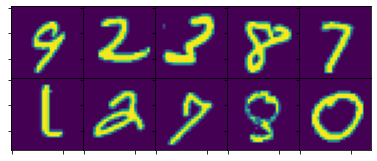

In [5]:
show_images(x_train)

#  Build a Neural Network from Scratch 
Building a neural netowork from scratch, then applying it to digit-classification using MNIST dataset

# References
[Basic Understanding of a Neural Network](https://www.youtube.com/watch?v=w8yWXqWQYmU&list=WL&index=48)

~~[Neural Network based on this PDF](https://github.com/josh-truong/Coursera-Machine-Learning-Standford/blob/master/Week%205/ex4/ex4.pdf)~~

[Supervised Deep Learning](https://bfeba431-a-62cb3a1a-s-sites.googlegroups.com/site/deeplearningcvpr2014/ranzato_cvpr2014_DLtutorial.pdf?attachauth=ANoY7crCm3oHioj51nzwHMP5oW8PmHeniUoyTPG-qXhwrZiwgB17QymsE5fR5snwXHijU1qdXc3bYM9o-KRJ865qd52ZCUpdlBxSHooXB0icmP8F37-eD4EE9-x6USV8qef2KgxRSdq0jpoypPtaVrszqSZ8AjE3RxAjUxcPL69yhPO50y-rsj8ApCQlheFP9L7XbOf1COszw_kEP6pNcCSQZvYjjI2Op5gPOi4qEaCO5B08lSnEhMk6IAkvufYhu1K7EreTieYA&attredirects=1)

# Goal
1. Input layer: Given 28x28 pixel images → 784 pixels. Our input layer will have 784 nodes.
2. Hidden layer:
3. Output layer: There are 10 distinct labels within our dataset. Therefore, our output layer will have 10 nodes.

# Multi-label Classification: Activation Functions
[Pros and cons of sigmoid, tanh, relu, leaky relu, and softmax activation functions](https://medium.com/@cmukesh8688/activation-functions-sigmoid-tanh-relu-leaky-relu-softmax-50d3778dcea5)
- If there's more than one "right answer" use a sigmoid function
  - Sigmoid functions will allow for assignment of high probability to all classes
$$S(\vec{z}) = \frac{1}{1+e^{-z}}$$
- If there's only one "right answer" use a softmax function
  - Softmax function will enforce that the sum of probabilities of the output class to equal one.
$$\sigma(\vec{z})_i = \frac{e^{z_i}}{\sum^{j=1}_{K} (e^{z_j})}$$
    - Probability of class i given input
    - $\sigma$ is softmax
    - $\vec{z}$ is the input vector
    - $K$ is the number of classes in the multi-label classifier
    - $e^{z_i}$ is the standard exponential function for input vector
    - $e^{z_j}$ is the standard exponential function for output vector
- Tanh converges quicker than sigmoid and logistic functions, and yields better accuracy.
- ReLu(rectified linear unit) most popular activation function. Trains six times faster than tanh
- LReLU(leaky rectified linear unit) developed to overcome one of the major shortcomings of ReLU.


In [6]:
class Activations:
  def sigmoid(self, z, prime=False):
    """Compute the sigmoid of vector z or sigmoid prime."""
    sigmoid = 1.0 / (1 + np.exp(-z))
    if (prime):
      return sigmoid * (1 - sigmoid)
    return sigmoid

  def tanh(self, z, prime=False):
    """Compute the tanh of vector z or tanh prime."""
    tanh = (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
    if (prime):
      return 1.0 - np.power(tanh, 2)
    return tanh

  def relu(self, z, prime=False):
    """Compute the ReLU of vector z or ReLU prime."""
    if (prime):
      return z > 0
    return np.maximum(0, z)

  def leakyrelu(self, z, alpha, prime=False):
    """Compute the leakyrelu of vector z or leakyrelu prime."""
    if (prime):
      return 1 if z > 0 else alpha
    return np.maximum(alpha * z, z)

  def softmax(self, z):
    """Compute the softmax of vector z."""
    exps = np.exp(z - z.max())
    return exps / np.sum(exps, axis=0)

## Basic Neural Network
Our NN will consists of 3 layers: input(784 nodes), hidden(10 nodes), and output(10 nodes) layer

### Forward Propagation
Forward propagation takes an input and gives a prediction.

$\underset{784 \times m}{A_{0}} = X$
- $A_{0}$ - input layer
- $m$ - size of training set

---

#### Layer 1 (input and hidden layer)
$\underset{10 \times m}{Z_{1}} = \overbrace{\underset{10 \times 784}{W_{1}} \cdot \underset{784 \times m}{A_{0}}}^{10 \times m} + \underset{10 \times 1}{b_{1}}$
- $Z_{1}$ is the <u>unactivated layer</u> of the <u>input</u> and <u>hidden</u> layer.
- $W_{1}$ and $b_{1}$ are the weights and biases of the <u>input</u> and <u>hidden</u> layer.

$\underset{10 \times m}{A_{1}} = g(Z_{1}) = \text{ReLU}(Z_{1})$
- $A_{1}$ - hidden layer
- $g(x)$ - represents an activation function. In this case, $g(x)$ = ReLU activation function.
- Weights and biases alone is not enough for our learning model, essentially our NN would become a composition of linear functions, which is a linear function. Essentially we would have a fancy linear regression model.
- Adding a ReLU layer, will add complexity to our model by applying piece-wise linear tiling. Allowing for non-linearity in an inherently linear model.

---

#### Layer 2 (hidden and output layer)
$\underset{10 \times m}{Z_{2}} = \overbrace{\underset{10 \times 10}{W_{2}} \cdot \underset{10 \times m}{A_{1}}}^{10 \times m} + \underset{10 \times 1}{b_{2}}$
- $Z_{2}$ is the <u>unactivated layer</u> between the <u>hidden</u> and <u>output</u> layer.
- $W_{2}$ and $b_{2}$ are the weights and biases of the <u>hidden</u> and <u>output</u> layer.

$A_{2} = \text{softmax}(Z_{2})$
- Second application of an activation function on $Z_{2}$
- Since there are no more layers to evaluate. We should apply the softmax function to retrieve the predicted output layer.
- Softmax activation function will enforce that the sum of probabilities of the output class to equal to 1.

---
---

### Backpropagation
Backpropagation starts with our prediction and determine how much the prediction deviated by the actual label, essentially calculating our error. Determine how much the weights and biases contributed to the error the outcome and adjust.

---

#### Determine how much the weights and biases contributed to ther error in layer 2
$\underset{10 \times m}{dZ_{2}} = \underset{10 \times m}{A_{2}} - \underset{10 \times m}{Y}$
- $dZ_2$ derivative of the softmax activation function. Essentially calculating the error between predicted and actual values.
- $A_{2}$ is our prediction
- $Y$ is a one hot encoded matrix of our actual label.
  - One hot encoding converts our categorical value into a new categorical column and assign a binary value of 1 or 0 to those columns.
Given a labeled set $Y$, one hot encode $Y$.

| Y   | AA_one_hot | AB_one_hot | CD_one_hot |
| ----| :--------: | :--------: | :--------: |
| AA  | 1          | 0          | 0          |
| AB  | 0          | 1          | 0          |
| CD  | 0          | 0          | 1          |
| AA  | 1          | 0          | 0          |

$\underset{10 \times 10}{dW_{2}} = \frac{1}{m} \cdot \underset{10 \times m}{dZ_{2}} \cdot \underset{m \times 10}{A_{1}^{T}}$
- $dW_{2}$ derivative of the cost function with respect to the weights in layer 2(between output and hidden layer).
- Determining how much the weights contributed to the error.

$\underset{10 \times 1}{db_{2}} = \frac{1}{m} \cdot \underset{10 \times 1}{\sum dZ_{2}}$
- $db_{2}$ derivative of the cost function with respect to the biases in layer 2(between output and hidden layer).
- Determining how much the biases contributed to the error.
- Average of absolute error

---

#### Determine how much the weights and biases contributed to ther error in layer 1
$\underset{10 \times m}{dZ_{1}} = (\underset{10 \times 10}{W_{2}^{T}} \cdot \underset{10 \times m}{dZ_{2}}) \circ \underset{10 \times m}{g'(Z_{1})}$
- "$\circ$" denotes Hadamard product (element-wise product)
- Taking the errors $dZ_2$ and applying it to the weights, $W_{2}$, to get to the errors in layer 1. $g'()$ is the derivative of the activation function. By element-wise product, we get the proper error values of layer 1 because we have undone the activation function.

$\underset{10 \times 784}{dW_{1}} = \frac{1}{m} \cdot \underset{10 \times m}{dZ_{1}} \cdot \underset{m \times 784}{X^{T}}$

$\underset{10 \times 1}{db_{1}} = \frac{1}{m} \cdot \underset{10 \times 1}{\sum dZ_{1}}$

---
---
### Update weights and biases
Given a hyperparameter $\alpha$, learning rate. Update the weights and biases.

$W_{1} = W_{1} - \alpha \cdot dW_{1}$

$b_{1} = b_{1} - \alpha \cdot db_{1}$

$W_{2} = W_{2} - \alpha \cdot dW_{2}$

$b_{2} = b_{2} - \alpha \cdot db_{2}$


In [39]:
# https://stackoverflow.com/questions/44883861/initial-bias-values-for-a-neural-network

class NeuralNetwork:
  def __init__(self, input_layer_size, output_layer_size, hidden_layer_size):
    self.input_layer_size =  input_layer_size
    self.output_layer_size = output_layer_size
    self.hidden_layer_size = hidden_layer_size
    self.n = self.m = None

    self.layer_size = 2
    self.W = self.B = None

  def _init_params(self):
    self.W = [
        np.random.rand(self.hidden_layer_size, self.input_layer_size) * np.sqrt(1./self.input_layer_size),
        np.random.rand(self.output_layer_size, self.hidden_layer_size) * np.sqrt(1./self.hidden_layer_size)
    ]
    self.B = [
        np.zeros((self.hidden_layer_size, 1)),
        np.zeros((self.output_layer_size, 1))
    ]

  def one_hot(self, x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k."""
    return np.array(x[:, None] == np.arange(k), dtype)

  def forward_propagate(self, X):
    # Layer 1
    Z1 = self.W[0] @ X + self.B[0]
    A1 = Activations().relu(Z1)

    # Layer 2
    Z2 = self.W[1] @ A1 + self.B[1]
    A2 = Activations().softmax(Z2)
    return Z1, A1, Z2, A2

  def backward_propagate(self, X, Y, Z1, A1, Z2, A2):
    n, m = X.shape
    Y = self.one_hot(Y, self.output_layer_size)
    # Layer 2
    dZ2 = A2 - Y.T
    dW2 = (dZ2 @ A1.T) / m
    dB2 = np.sum(dZ2) / m

    # Layer 1
    dZ1 = np.multiply(self.W[1].T @ dZ2, Activations().relu(Z1, prime=True))
    dW1 = (dZ1 @ X.T) / m
    dB1 = np.sum(dZ1) / m
    return dW2, dB2, dW1, dB1
  
  def update_params(self, dW2, dB2, dW1, dB1, alpha):
    self.W = [
        self.W[0] - alpha * dW1,
        self.W[1] - alpha * dW2,
    ]
    self.B = [
        self.B[0] - alpha * dB1,
        self.B[1] - alpha * dB2
    ]

  def get_prediction(self, y):
    return np.argmax(y, 0)
  
  def get_accuracy(self, y, output):
    return np.mean(output == y)

  def cross_entropy_loss(self, y, output):
    """ L(y, ŷ) = −∑ylog(ŷ) """
    y = self.one_hot(y, self.output_layer_size)
    l_sum = np.sum(np.multiply(y.T, np.log(output)))
    m = y.shape[0]
    l = -(1./m) * l_sum
    return l

  def gradient_descent(self, X, Y, alpha):
    Z1, A1, Z2, A2 = self.forward_propagate(X)
    dW2, dB2, dW1, dB1 = self.backward_propagate(X, Y, Z1, A1, Z2, A2)
    self.update_params(dW2, dB2, dW1, dB1, alpha)
    return A2
  
  def train(self, x_train, y_train, x_test, y_test, alpha=0.1, iter=500):
    self._init_params()
    start_time = time.time()
    template = "Epoch {}: {:.2f}s, train acc={:.2f}, train loss={:.2f}, test acc={:.2f}, test loss={:.2f}"

    for i in range(iter):
      Y_predict = self.gradient_descent(x_train, y_train, alpha)

      if (i % 10 == 0):
        train_acc = self.get_accuracy(y_train, self.get_prediction(Y_predict))
        train_loss = self.cross_entropy_loss(y_train, Y_predict)

        _, _, _, A2 = self.forward_propagate(x_test)
        test_acc = self.get_accuracy(y_test, self.get_prediction(A2))
        test_loss = self.cross_entropy_loss(y_test, A2)
        print(template.format(i+1, time.time()-start_time, train_acc, train_loss, test_acc, test_loss))

input_layer_size  = 784 # 28x28 image = 784 pixels
hidden_layer_size = 20  # Any natural numbers
output_layer_size = 10  # Label has 10 distinct units
nn = NeuralNetwork(input_layer_size, output_layer_size, hidden_layer_size)
nn.train(x_train.T, y_train.T, x_test.T, y_test.T)

Epoch 1: 0.57s, train acc=0.10, train loss=2.49, test acc=0.12, test loss=2.31
Epoch 11: 5.30s, train acc=0.16, train loss=2.20, test acc=0.19, test loss=2.19
Epoch 21: 10.06s, train acc=0.48, train loss=2.07, test acc=0.51, test loss=2.05
Epoch 31: 14.70s, train acc=0.68, train loss=1.85, test acc=0.69, test loss=1.82
Epoch 41: 19.43s, train acc=0.72, train loss=1.57, test acc=0.73, test loss=1.53
Epoch 51: 24.28s, train acc=0.75, train loss=1.30, test acc=0.76, test loss=1.26
Epoch 61: 29.00s, train acc=0.77, train loss=1.09, test acc=0.78, test loss=1.05
Epoch 71: 33.69s, train acc=0.79, train loss=0.93, test acc=0.80, test loss=0.90
Epoch 81: 39.23s, train acc=0.81, train loss=0.83, test acc=0.81, test loss=0.80
Epoch 91: 43.91s, train acc=0.82, train loss=0.75, test acc=0.83, test loss=0.72
Epoch 101: 48.61s, train acc=0.83, train loss=0.69, test acc=0.84, test loss=0.66
Epoch 111: 53.33s, train acc=0.84, train loss=0.64, test acc=0.85, test loss=0.62
Epoch 121: 58.04s, train acc=

# Andrew Ng Deep Networks Course
### Weight Initialization for Deep Networks
$$W^{l} = \text{np.random.randn}(\text{shape}) \cdot \text{np.sqrt}(\frac{1}{n^{(l-1)}})$$


In [35]:
# # https://github.com/lionelmessi6410/Neural-Networks-from-Scratch/blob/main/NN-from-Scratch.ipynb
# class DeepNeuralNetwork():
#     def __init__(self, sizes, activation=Activations().sigmoid):
#         self.sizes = sizes
#         self.activation = activation
        
#         # Save all weights
#         self.params = self.initialize()
#         # Save all intermediate values, i.e. activations
#         self.cache = {}

#     def initialize(self):
#         # number of nodes in each layer
#         input_layer=self.sizes[0]
#         hidden_layer=self.sizes[1]
#         output_layer=self.sizes[2]
        
#         params = {
#             "W1": np.random.randn(hidden_layer, input_layer) * np.sqrt(1./input_layer),
#             "b1": np.zeros((hidden_layer, 1)) * np.sqrt(1./input_layer),
#             "W2": np.random.randn(output_layer, hidden_layer) * np.sqrt(1./hidden_layer),
#             "b2": np.zeros((output_layer, 1)) * np.sqrt(1./hidden_layer)
#         }
#         return params
    
#     def initialize_momemtum_optimizer(self):
#         momemtum_opt = {
#             "W1": np.zeros(self.params["W1"].shape),
#             "b1": np.zeros(self.params["b1"].shape),
#             "W2": np.zeros(self.params["W2"].shape),
#             "b2": np.zeros(self.params["b2"].shape),
#         }
#         return momemtum_opt

#     def feed_forward(self, x):
#         '''
#             y = σ(wX + b)
#         '''
#         self.cache["X"] = x
#         self.cache["Z1"] = np.matmul(self.params["W1"], self.cache["X"].T) + self.params["b1"]
#         self.cache["A1"] = self.activation(self.cache["Z1"])
#         self.cache["Z2"] = np.matmul(self.params["W2"], self.cache["A1"]) + self.params["b2"]
#         self.cache["A2"] = Activations().softmax(self.cache["Z2"])
#         return self.cache["A2"]
    
#     def back_propagate(self, y, output):
#         '''
#             This is the backpropagation algorithm, for calculating the updates
#             of the neural network's parameters.

#             Note: There is a stability issue that causes warnings. This is 
#                   caused  by the dot and multiply operations on the huge arrays.
                  
#                   RuntimeWarning: invalid value encountered in true_divide
#                   RuntimeWarning: overflow encountered in exp
#                   RuntimeWarning: overflow encountered in square
#         '''
#         current_batch_size = y.shape[0]
        
#         dZ2 = output - y.T
#         dW2 = (1./current_batch_size) * np.matmul(dZ2, self.cache["A1"].T)
#         db2 = (1./current_batch_size) * np.sum(dZ2, axis=1, keepdims=True)

#         dA1 = np.matmul(self.params["W2"].T, dZ2)
#         dZ1 = dA1 * self.activation(self.cache["Z1"], prime=True)
#         dW1 = (1./current_batch_size) * np.matmul(dZ1, self.cache["X"])
#         db1 = (1./current_batch_size) * np.sum(dZ1, axis=1, keepdims=True)

#         self.grads = {"W1": dW1, "b1": db1, "W2": dW2, "b2": db2}
#         return self.grads
                
#     def optimize(self, l_rate=0.1, beta=.9):
#         '''
#             Stochatic Gradient Descent (SGD):
#             θ^(t+1) <- θ^t - η∇L(y, ŷ)
            
#             Momentum:
#             v^(t+1) <- βv^t + (1-β)∇L(y, ŷ)^t
#             θ^(t+1) <- θ^t - ηv^(t+1)
#         '''
#         if self.optimizer == "sgd":
#             for key in self.params:
#                 self.params[key] = self.params[key] - l_rate * self.grads[key]
#         elif self.optimizer == "momentum":
#             for key in self.params:
#                 self.momemtum_opt[key] = (beta * self.momemtum_opt[key] + (1. - beta) * self.grads[key])
#                 self.params[key] = self.params[key] - l_rate * self.momemtum_opt[key]
#         else:
#             raise ValueError("Optimizer is currently not support, please use 'sgd' or 'momentum' instead.")

#     def accuracy(self, y, output):
#         return np.mean(np.argmax(y, axis=-1) == np.argmax(output.T, axis=-1))

#     def train(self, x_train, y_train, x_test, y_test, epochs=10, 
#               batch_size=64, optimizer='momentum', l_rate=0.1, beta=.9):
#         # Hyperparameters
#         self.epochs = epochs
#         self.batch_size = batch_size
#         num_batches = -(-x_train.shape[0] // self.batch_size)
        
#         # Initialize optimizer
#         self.optimizer = optimizer
#         if self.optimizer == 'momentum':
#             self.momemtum_opt = self.initialize_momemtum_optimizer()
        
#         start_time = time.time()
#         template = "Epoch {}: {:.2f}s, train acc={:.2f}, train loss={:.2f}, test acc={:.2f}, test loss={:.2f}"
        
#         # Train
#         for i in range(self.epochs):
#             # Shuffle
#             permutation = np.random.permutation(x_train.shape[0])
#             x_train_shuffled = x_train[permutation]
#             y_train_shuffled = y_train[permutation]

#             for j in range(num_batches):
#                 # Batch
#                 begin = j * self.batch_size
#                 end = min(begin + self.batch_size, x_train.shape[0]-1)
#                 x = x_train_shuffled[begin:end]
#                 y = y_train_shuffled[begin:end]
                
#                 # Forward
#                 output = self.feed_forward(x)
#                 # Backprop
#                 grad = self.back_propagate(y, output)
#                 # Optimize
#                 self.optimize(l_rate=l_rate, beta=beta)

#             # Evaluate performance
#             # Training data
#             output = self.feed_forward(x_train)
#             train_acc = self.accuracy(y_train, output)
#             train_loss = self.cross_entropy_loss(y_train, output)
#             # Test data
#             output = self.feed_forward(x_test)
#             test_acc = self.accuracy(y_test, output)
#             test_loss = self.cross_entropy_loss(y_test, output)
#             print(template.format(i+1, time.time()-start_time, train_acc, train_loss, test_acc, test_loss))
#     def cross_entropy_loss(self, y, output):
#         '''
#             L(y, ŷ) = −∑ylog(ŷ).
#         '''
        
#         l_sum = np.sum(np.multiply(y.T, np.log(output)))
#         m = y.shape[0]
#         l = -(1./m) * l_sum
#         print(l_sum)
#         return l

# def one_hot(x, k, dtype=np.float32):
#   """Create a one-hot encoding of x of size k."""
#   return np.array(x[:, None] == np.arange(k), dtype)

In [53]:
# # Sigmoid + Momentum
# dnn = DeepNeuralNetwork(sizes=[784, 64, 10])
# dnn.train(x_train, one_hot(y_train, 10), x_test, one_hot(y_test, 10), batch_size=128, optimizer='momentum', l_rate=4, beta=.9)

In [ ]:
# # ReLU + SGD
# dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation=Activations().relu)
# dnn.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='sgd', l_rate=0.05)